,count,pct
toxic,15294,9.584
obscene,8449,5.295
insult,7877,4.936
severe_toxic,1595,1.000
identity_hate,1405,0.880
threat,478,0.300


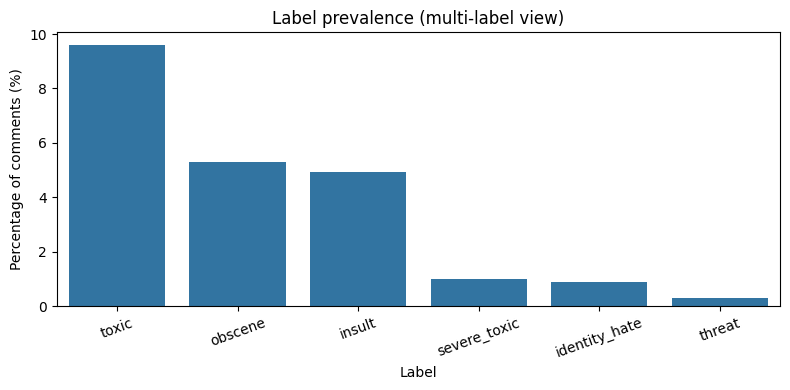

In [8]:

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

LABELS = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
label_counts = train[LABELS].sum().sort_values(ascending=False)
label_pct = (label_counts / len(train) * 100).round(3)
label_summary = pd.DataFrame({"count": label_counts, "pct": label_pct})
display(label_summary)

plt.figure(figsize=(8,4))
sns.barplot(x=label_summary.index, y=label_summary["pct"])
plt.ylabel("Percentage of comments (%)")
plt.xlabel("Label")
plt.title("Label prevalence (multi-label view)")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

In [2]:
# @title SVM

import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE # Though not used in this iteration, keeping for context
from sklearn.pipeline import make_pipeline

# === Load datasets ===
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
test_labels = pd.read_csv("test_labels.csv")

# === Clean test_labels ===
test_labels = test_labels[test_labels['toxic'] != -1]
test = test[test['id'].isin(test_labels['id'])]


# === Create target variable ====
def compute_binary_harassment(df):
    """
    Computes a binary target:
    1 if the comment has ANY of the toxic labels (sum > 0)
    0 if the comment has NONE of the toxic labels (sum == 0)
    """
    harassment_score = df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum(axis=1)
    return (harassment_score > 0).astype(int)

train['harassment_binary'] = compute_binary_harassment(train)
test_labels['harassment_binary'] = compute_binary_harassment(test_labels)

# === Features and target  ===
X_train = train['comment_text']
y_train_bin = train['harassment_binary']
X_test = test['comment_text']
y_test_bin = test_labels['harassment_binary']

#  Replace NaN values with empty strings before vectorization
print("Cleaning text data (replacing NaN with empty strings)...")
X_train = X_train.fillna('')
X_test = X_test.fillna('')

# === 1. UNIGRAM FEATURE EXTRACTION  ===
print("\nVectorizing Unigram features...")
vectorizer_uni = CountVectorizer(stop_words='english', ngram_range=(1, 1), max_features=2000)
X_train_uni = vectorizer_uni.fit_transform(X_train)
X_test_uni = vectorizer_uni.transform(X_test)
X_train_bal_uni, y_train_bal_uni = X_train_uni, y_train_bin # Using binary target

# === 2. BIGRAM FEATURE EXTRACTION  ===
print("Vectorizing Bigram features...")
vectorizer_bi = CountVectorizer(stop_words='english', ngram_range=(2, 2), max_features=2000)
X_train_bi = vectorizer_bi.fit_transform(X_train)
X_test_bi = vectorizer_bi.transform(X_test)
X_train_bal_bi, y_train_bal_bi = X_train_bi, y_train_bin # Using binary target


def train_and_evaluate_svm_binary(X_train_data, y_train_data, X_test_data, y_test_data, feature_name):
    """Trains LinearSVC for binary classification and prints Classification Report metrics."""

    # Initialize the Linear SVM model
    svm_linear = LinearSVC(
        C=1.0,
        random_state=42,
        max_iter=5000,
        dual=True,
    )

    print(f"\nTraining SVM on **{feature_name}** features (BINARY CLASSIFICATION)...")
    svm_linear.fit(X_train_data, y_train_data)

    # Predict on test set
    y_pred = svm_linear.predict(X_test_data)

    # Evaluate
    print(f"\nClassification Report (Linear SVM - {feature_name} Features):")
    # '0' = Not Harassing, '1' = Harassing
    print(classification_report(y_test_data, y_pred, digits=3, zero_division=0))

    # Confusion matrix
    cm = confusion_matrix(y_test_data, y_pred)
    print(f"\nConfusion Matrix ({feature_name}):")
    # Rows: True Labels (0, 1), Columns: Predicted Labels (0, 1)
    print(cm)

    return y_pred



print("\n" + "="*50)
print("=== STARTING BINARY CLASSIFICATION EVALUATION ===")
print("="*50)

# 1. Evaluate Unigrams (Binary)
y_pred_uni_bin = train_and_evaluate_svm_binary(
    X_train_bal_uni, y_train_bal_uni, X_test_uni, y_test_bin, "Unigram"
)

# 2. Evaluate Bigrams (Binary)
y_pred_bi_bin = train_and_evaluate_svm_binary(
    X_train_bal_bi, y_train_bal_bi, X_test_bi, y_test_bin, "Bigram"
)


# === Optional: Save predictions for the LAST model evaluated (Bigrams) ===
output_bi_bin = pd.DataFrame({'id': test['id'], 'predicted_binary': y_pred_bi_bin})
output_bi_bin.to_csv("svm_predictions_bigram_binary.csv", index=False)


print("\nPredictions for Bigram model (Binary Classification) saved to svm_predictions_bigram_binary.csv")

Cleaning text data (replacing NaN with empty strings)...

Vectorizing Unigram features...
Vectorizing Bigram features...

=== STARTING BINARY CLASSIFICATION EVALUATION ===

Training SVM on **Unigram** features (BINARY CLASSIFICATION)...


/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



Classification Report (Linear SVM - Unigram Features):
              precision    recall  f1-score   support

           0      0.958     0.956     0.957     57735
           1      0.603     0.616     0.609      6243

    accuracy                          0.923     63978
   macro avg      0.780     0.786     0.783     63978
weighted avg      0.924     0.923     0.923     63978


Confusion Matrix (Unigram):
[[55201  2534]
 [ 2400  3843]]

Training SVM on **Bigram** features (BINARY CLASSIFICATION)...

Classification Report (Linear SVM - Bigram Features):
              precision    recall  f1-score   support

           0      0.908     0.997     0.951     57735
           1      0.729     0.069     0.125      6243

    accuracy                          0.907     63978
   macro avg      0.819     0.533     0.538     63978
weighted avg      0.891     0.907     0.870     63978


Confusion Matrix (Bigram):
[[57576   159]
 [ 5815   428]]

Predictions for Bigram model (Binary Classification

/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [3]:
# @title Random Forest
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import LinearSVC
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import make_pipeline

# === Load datasets ===
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
test_labels = pd.read_csv("test_labels.csv")

# === Clean test_labels ===
# Remove rows where toxic label is -1 (unlabeled data in test set)
test_labels = test_labels[test_labels['toxic'] != -1]
# Filter the test data to only include the labeled comments
test = test[test['id'].isin(test_labels['id'])]

def compute_binary_harassment(df):
    """
    Computes a binary target: 1 if the comment has ANY toxic labels, 0 otherwise.
    """
    harassment_score = df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum(axis=1)
    # Convert sum > 0 to 1, and sum == 0 to 0
    return (harassment_score > 0).astype(int)

train['harassment_binary'] = compute_binary_harassment(train)
test_labels['harassment_binary'] = compute_binary_harassment(test_labels)

# === Features and target ===
X_train = train['comment_text']
y_train_bin = train['harassment_binary']
X_test = test['comment_text']
y_test_bin = test_labels['harassment_binary']

#  FIX: Replace NaN values with empty strings before vectorization
print("Cleaning text data (replacing NaN with empty strings)...")
X_train = X_train.fillna('')
X_test = X_test.fillna('')


print("\nVectorizing Unigram features (max_features=1000, min_df=5)...")

# Speed Optimization: Reduced max_features and added min_df to shrink the matrix size
vectorizer_uni = CountVectorizer(
    stop_words='english',
    ngram_range=(1, 1),
    max_features=1000,
    min_df=5
)

X_train_uni = vectorizer_uni.fit_transform(X_train)
X_test_uni = vectorizer_uni.transform(X_test)


def train_and_evaluate_random_forest(X_train_data, y_train_data, X_test_data, y_test_data, feature_name):
    """Trains a Random Forest Classifier and prints Classification Report metrics."""

    # Initialize the Random Forest model

    rf_classifier = RandomForestClassifier(
        n_estimators=100,
        random_state=42,
        n_jobs=-1,
        class_weight='balanced'
    )

    print(f"\nTraining Random Forest on **{feature_name}** features (BINARY CLASSIFICATION)...")
    rf_classifier.fit(X_train_data, y_train_data)

    # Predict on test set
    y_pred = rf_classifier.predict(X_test_data)

    # Evaluate
    print(f"\nClassification Report (Random Forest - {feature_name} Features):")
    print(classification_report(y_test_data, y_pred, digits=3, zero_division=0))

    # Confusion matrix
    cm = confusion_matrix(y_test_data, y_pred)
    print(f"\nConfusion Matrix ({feature_name}):")
    # Rows: True Labels (0, 1), Columns: Predicted Labels (0, 1)
    print(cm)

    return y_pred


print("\n" + "="*60)
print("=== STARTING RANDOM FOREST CLASSIFICATION (UNIGRAMS) ===")
print("="*60)

y_pred_rf_uni = train_and_evaluate_random_forest(
    X_train_uni, y_train_bin, X_test_uni, y_test_bin, "Unigram"
)

# === Optional: Save predictions ===
output_rf_uni = pd.DataFrame({'id': test['id'], 'predicted_binary_rf_uni': y_pred_rf_uni})
output_rf_uni.to_csv("rf_predictions_unigram_binary.csv", index=False)

print("\nPredictions for Random Forest Unigram model saved to rf_predictions_unigram_binary.csv")

Cleaning text data (replacing NaN with empty strings)...

Vectorizing Unigram features (max_features=1000, min_df=5)...

=== STARTING RANDOM FOREST CLASSIFICATION (UNIGRAMS) ===

Training Random Forest on **Unigram** features (BINARY CLASSIFICATION)...

Classification Report (Random Forest - Unigram Features):
              precision    recall  f1-score   support

           0      0.973     0.873     0.920     57735
           1      0.397     0.775     0.525      6243

    accuracy                          0.863     63978
   macro avg      0.685     0.824     0.723     63978
weighted avg      0.917     0.863     0.882     63978


Confusion Matrix (Unigram):
[[50393  7342]
 [ 1405  4838]]

Predictions for Random Forest Unigram model saved to rf_predictions_unigram_binary.csv


In [5]:
# @title Bi-LSTM
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np



print("\n--- Tokenizing and Padding Text Data for Deep Learning Models ---")

# Define vocabulary size and maximum sequence length
VOCAB_SIZE = 10000
MAX_LEN = 100

# Initialize Tokenizer
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token="<unk>")

# Fit on training text data
tokenizer.fit_on_texts(X_train)

# Convert text to sequences
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

# Pad sequences to a fixed length
X_train_padded = pad_sequences(X_train_sequences, maxlen=MAX_LEN, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=MAX_LEN, padding='post', truncating='post')

print(f"Original X_train shape: {X_train.shape}")
print(f"Padded X_train shape: {X_train_padded.shape}")
print(f"Original X_test shape: {X_test.shape}")
print(f"Padded X_test shape: {X_test_padded.shape}")
print(f"Vocabulary size: {VOCAB_SIZE}")
print(f"Max sequence length: {MAX_LEN}")



--- Tokenizing and Padding Text Data for Deep Learning Models ---
Original X_train shape: (159571,)
Padded X_train shape: (159571, 100)
Original X_test shape: (63978,)
Padded X_test shape: (63978, 100)
Vocabulary size: 10000
Max sequence length: 100


In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import pandas as pd

# --- 2. Model Definition (Pure Bi-LSTM) ---

print("\n--- Defining Pure Bi-LSTM Model Architecture ---")

# Ensure VOCAB_SIZE, MAX_LEN, X_train_padded, X_test_padded are defined from a previous cell (text preprocessing)
embedding_dim = 128 # Dimensionality of the word embeddings
lstm_units = 64     # Number of units in the LSTM layer

bi_lstm_model = Sequential([
    Embedding(VOCAB_SIZE, embedding_dim, input_length=MAX_LEN),
    Bidirectional(LSTM(lstm_units)), # Bi-LSTM layer, no return_sequences=True as it's the last recurrent layer
    Dense(64, activation='relu'),                          # Dense hidden layer
    Dropout(0.5),                                          # Dropout for regularization
    Dense(1, activation='sigmoid')                         # Output layer for binary classification
])

bi_lstm_model.summary()

# --- 3. Model Compilation (Bi-LSTM) ---

print("\n--- Compiling Bi-LSTM Model ---")

bi_lstm_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# --- 4. Model Training (Bi-LSTM) ---

print("\n--- Training Bi-LSTM Model ---")

epochs = 5  # Number of training epochs, can be tuned
batch_size = 32 # Batch size, can be tuned

history_bi_lstm = bi_lstm_model.fit(
    X_train_padded, # Ensure X_train_padded is defined from prev cell
    y_train_bin,    # Ensure y_train_bin is defined from prev cell
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.2, # Use 20% of training data for validation
    verbose=1
)

# --- 5. Model Evaluation (Bi-LSTM) ---

print("\n--- Evaluating Bi-LSTM Model on Test Data ---")

loss_bi_lstm, accuracy_bi_lstm = bi_lstm_model.evaluate(X_test_padded, y_test_bin, verbose=0) # Ensure X_test_padded, y_test_bin are defined from prev cell
print(f"Test Loss (Bi-LSTM): {loss_bi_lstm:.4f}")
print(f"Test Accuracy (Bi-LSTM): {accuracy_bi_lstm:.4f}")

# Predict on test data
y_pred_proba_bi_lstm = bi_lstm_model.predict(X_test_padded)
y_pred_bi_lstm = (y_pred_proba_bi_lstm > 0.5).astype(int)

# Classification Report
print("\nClassification Report (Pure Bi-LSTM):")
print(classification_report(y_test_bin, y_pred_bi_lstm, digits=3, zero_division=0))

# Confusion Matrix
cm_bi_lstm = confusion_matrix(y_test_bin, y_pred_bi_lstm)
print("\nConfusion Matrix (Pure Bi-LSTM):")
print(cm_bi_lstm)

# Optional: Save predictions
output_bi_lstm = pd.DataFrame({'id': test['id'], 'predicted_binary_bi_lstm': y_pred_bi_lstm.flatten()}) # Ensure 'test' DataFrame is available
output_bi_lstm.to_csv("bi_lstm_predictions_binary.csv", index=False)
print("\nPredictions for Bi-LSTM model saved to bi_lstm_predictions_binary.csv")


--- Defining Pure Bi-LSTM Model Architecture ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


--- Compiling Bi-LSTM Model ---

--- Training Bi-LSTM Model ---
Epoch 1/5
3990/3990 ━━━━━━━━━━━━━━━━━━━━ 59s 13ms/step - accuracy: 0.9399 - loss: 0.1887 - val_accuracy: 0.9632 - val_loss: 0.1056
Epoch 2/5
3990/3990 ━━━━━━━━━━━━━━━━━━━━ 53s 13ms/step - accuracy: 0.9659 - loss: 0.0942 - val_accuracy: 0.9628 - val_loss: 0.1075
Epoch 3/5
3990/3990 ━━━━━━━━━━━━━━━━━━━━ 53s 13ms/step - accuracy: 0.9707 - loss: 0.0767 - val_accuracy: 0.9631 - val_loss: 0.1138
Epoch 4/5
3990/3990 ━━━━━━━━━━━━━━━━━━━━ 52s 13ms/step - accuracy: 0.9774 - loss: 0.0572 - val_accuracy: 0.9616 - val_loss: 0.1509
Epoch 5/5
3990/3990 ━━━━━━━━━━━━━━━━━━━━ 53s 13ms/step - accuracy: 0.9841 - loss: 0.0412 - val_accuracy: 0.9580 - val_loss: 0.1695

--- Evaluating Bi-LSTM Model on Test Data ---
Test Loss (Bi-LSTM): 0.3589
Test Accuracy (Bi-LSTM): 0.9063
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step

Classification Report (Pure Bi-LSTM):
              precision    recall  f1-score   support

           0      0.982     0.913   

In [7]:
# @title CNN
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import pandas as pd

# --- 2. Model Definition (Pure CNN) ---

print("\n--- Defining CNN Model Architecture ---")
# VOCAB_SIZE = 10000
# MAX_LEN = 100
embedding_dim = 128
filters = 128
kernel_size = 5

cnn_model = Sequential([
    Embedding(VOCAB_SIZE, embedding_dim, input_length=MAX_LEN),
    Conv1D(filters, kernel_size, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

cnn_model.summary()

# --- 3. Model Compilation (CNN) ---

print("\n--- Compiling CNN Model ---")

cnn_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# --- 4. Model Training (CNN) ---

print("\n--- Training CNN Model ---")

epochs = 5
batch_size = 32

history_cnn = cnn_model.fit(
    X_train_padded,
    y_train_bin,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.2,
    verbose=1
)

# --- 5. Model Evaluation (CNN) ---

print("\n--- Evaluating CNN Model on Test Data ---")

loss_cnn, accuracy_cnn = cnn_model.evaluate(X_test_padded, y_test_bin, verbose=0)
print(f"Test Loss (CNN): {loss_cnn:.4f}")
print(f"Test Accuracy (CNN): {accuracy_cnn:.4f}")

# Predict on test data
y_pred_proba_cnn = cnn_model.predict(X_test_padded)
y_pred_cnn = (y_pred_proba_cnn > 0.5).astype(int)

# Classification Report
print("\nClassification Report (Pure CNN):")
print(classification_report(y_test_bin, y_pred_cnn, digits=3, zero_division=0))

# Confusion Matrix
cm_cnn = confusion_matrix(y_test_bin, y_pred_cnn)
print("\nConfusion Matrix (Pure CNN):")
print(cm_cnn)

# Optional: Save predictions
output_cnn = pd.DataFrame({'id': test['id'], 'predicted_binary_cnn': y_pred_cnn.flatten()}) # Ensure 'test' DataFrame is available
output_cnn.to_csv("cnn_predictions_binary.csv", index=False)
print("\nPredictions for CNN model saved to cnn_predictions_binary.csv")


--- Defining Pure CNN Model Architecture ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


--- Compiling CNN Model ---

--- Training CNN Model ---
Epoch 1/5
3990/3990 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - accuracy: 0.9400 - loss: 0.1822 - val_accuracy: 0.9603 - val_loss: 0.1092
Epoch 2/5
3990/3990 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9662 - loss: 0.0914 - val_accuracy: 0.9617 - val_loss: 0.1075
Epoch 3/5
3990/3990 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9772 - loss: 0.0603 - val_accuracy: 0.9597 - val_loss: 0.1315
Epoch 4/5
3990/3990 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9886 - loss: 0.0320 - val_accuracy: 0.9573 - val_loss: 0.1747
Epoch 5/5
3990/3990 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9944 - loss: 0.0186 - val_accuracy: 0.9544 - val_loss: 0.2083

--- Evaluating CNN Model on Test Data ---
Test Loss (CNN): 0.3862
Test Accuracy (CNN): 0.9017
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step

Classification Report (Pure CNN):
              precision    recall  f1-score   support

           0      0.982     0.908     0.943     57735
           